## Create your environment and enter " pip install -r requirements.txt "

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset

AB_PATH = "../data/ab_data.csv"
COUNTRIES_PATH = "../data/countries.csv"

ab = pd.read_csv(AB_PATH)
ab.head()

countries = pd.read_csv(COUNTRIES_PATH)
countries.head()

# Merge datasets
df = ab.merge(countries, how='left', on='user_id')
df.columns = [c.strip().lower() for c in df.columns]
display(df)


,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US
...,...,...,...,...,...,...
294477,697314,20:29.0,control,old_page,0,US
294478,715931,40:24.5,treatment,new_page,0,UK
294479,759899,20:29.0,treatment,new_page,0,US
294480,759899,20:29.0,treatment,new_page,0,US


In [3]:

# Basic info
print(f"Original shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Check for duplicate user IDs (adjust column name as needed)
user_col = 'user_id' 
if user_col in df.columns:
    print(f"Unique users: {df[user_col].nunique()}")
    print(f"Total records: {len(df)}")
    duplicated_users = len(df) - df[user_col].nunique()
    print(f"Duplicate user records: {duplicated_users}")

# CLEANING STEPS

# 1. Remove completely duplicate rows
df = df.drop_duplicates()

# 2. Handle missing values
# Fill missing values with 0 for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Fill missing values with 'Unknown' for text columns
text_cols = df.select_dtypes(include=['object']).columns
df[text_cols] = df[text_cols].fillna('Unknown')

# Final check
print(f"\nAfter cleaning:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Save cleaned data
df.to_csv('../data/cleaned_data.csv', index=False)
print("Saved as 'cleaned_data.csv'")

Original shape: (294482, 6)
Columns: ['user_id', 'timestamp', 'group', 'landing_page', 'converted', 'country']

Missing values:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
country         0
dtype: int64

Duplicate rows: 2
Unique users: 290585
Total records: 294482
Duplicate user records: 3897

After cleaning:
Shape: (294480, 6)
Missing values: 0
Saved as 'cleaned_data.csv'


### Data Validation

1. Landing page consistency 
2. 50/50 Check
3. Country Balance

In [4]:
# 1. Landing page consistency
df = pd.read_csv('../data/cleaned_data.csv')

# Check consistency between group and landing_page
control_check = df[df['group'] == 'control']['landing_page'].value_counts()
treatment_check = df[df['group'] == 'treatment']['landing_page'].value_counts()

print("Control group:")
print(control_check)
print("\nTreatment group:")
print(treatment_check)

# Remove inconsistent records
clean_df = df[~((df['group'] == 'control') & (df['landing_page'] == 'new_page') | 
               (df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))]

# Verify the cleaning worked
print("\nAfter cleaning:")
control_check_clean = clean_df[clean_df['group'] == 'control']['landing_page'].value_counts()
treatment_check_clean = clean_df[clean_df['group'] == 'treatment']['landing_page'].value_counts()

print("Control group:")
print(control_check_clean)
print("\nTreatment group:")
print(treatment_check_clean)

# Save cleaned data
df.to_csv('../data/cleaned_data.csv', index=False)
print("\nSaved as 'cleaned_data.csv'")

Control group:
landing_page
old_page    145274
new_page      1928
Name: count, dtype: int64

Treatment group:
landing_page
new_page    145313
old_page      1965
Name: count, dtype: int64

After cleaning:
Control group:
landing_page
old_page    145274
Name: count, dtype: int64

Treatment group:
landing_page
new_page    145313
Name: count, dtype: int64

Saved as 'cleaned_data.csv'


In [5]:
# 2. 50/50 Check
# Check group allocation ratio
group_counts = df['group'].value_counts()
group_percentages = df['group'].value_counts(normalize=True) * 100

print("Group allocation:")
print(group_counts)
print(f"\nPercentages:")
print(group_percentages)

Group allocation:
group
treatment    147278
control      147202
Name: count, dtype: int64

Percentages:
group
treatment    50.012904
control      49.987096
Name: proportion, dtype: float64


Country distribution across groups:
group    control  treatment
country                    
CA          7302       7393
UK         36841      36578
US        103059     103307

Country percentages by group:
group    control  treatment
country                    
CA         49.69      50.31
UK         50.18      49.82
US         49.94      50.06

Chi-square test for country balance:
Chi2: 1.7841, p-value: 0.4098
✓ Countries are balanced across groups


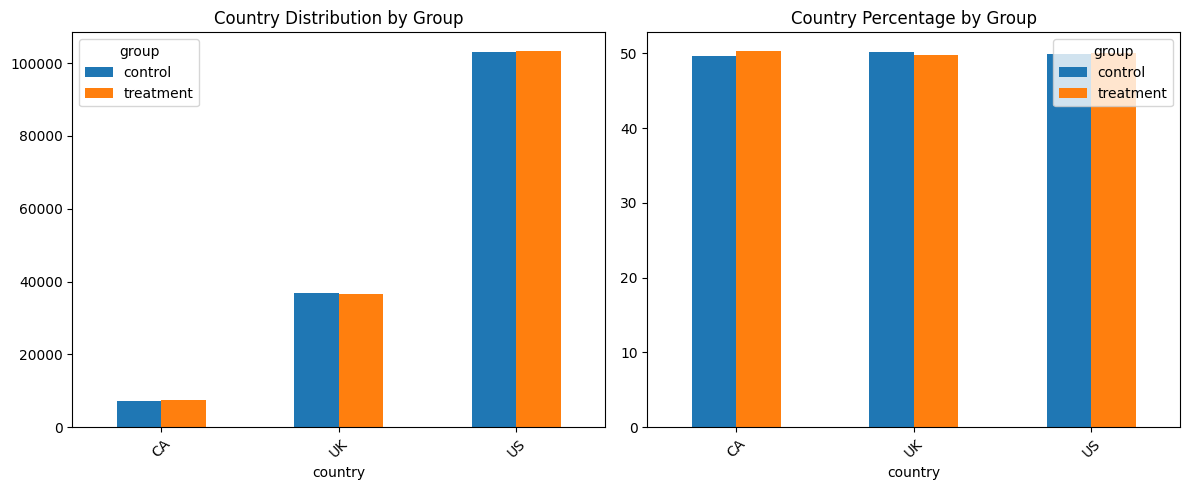

In [6]:
# 3. Country Balance
# Create contingency table for country vs group
country_crosstab = pd.crosstab(df['country'], df['group'])
print("Country distribution across groups:")
print(country_crosstab)

# Calculate percentages
country_percentages = pd.crosstab(df['country'], df['group'], normalize='index') * 100
print("\nCountry percentages by group:")
print(country_percentages.round(2))

# Chi-square test for country balance
chi2_country, p_country, dof, expected = stats.chi2_contingency(country_crosstab)
print(f"\nChi-square test for country balance:")
print(f"Chi2: {chi2_country:.4f}, p-value: {p_country:.4f}")

if p_country > 0.05:
    print("✓ Countries are balanced across groups")
else:
    print("⚠ Countries may not be balanced across groups")
    
# Visualise country distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
country_crosstab.plot(kind='bar', ax=ax[0])
ax[0].set_title('Country Distribution by Group')
ax[0].tick_params(axis='x', rotation=45)

country_percentages.plot(kind='bar', ax=ax[1])
ax[1].set_title('Country Percentage by Group')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### Exploratory Data Analysis 

1. Calculate conversion rates
2. Compare conversion rate by group and by country

Overall Conversion Rate: 0.1196

Conversion Rate by Group:
group
control      0.120386
treatment    0.118806
Name: converted, dtype: float64

Conversion Rate by Country and Group:
group    control  treatment
country                    
CA        0.1188     0.1119
UK        0.1200     0.1212
US        0.1206     0.1185

Conversion Counts & Rates by Country and Group:
                    count    sum  conversion_rate
country group                                    
CA      control      7198    855           0.1188
        treatment    7301    817           0.1119
UK      control     36360   4364           0.1200
        treatment   36106   4375           0.1212
US      control    101716  12270           0.1206
        treatment  101906  12072           0.1185


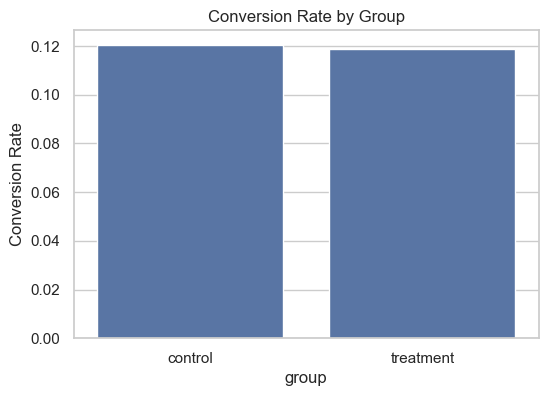

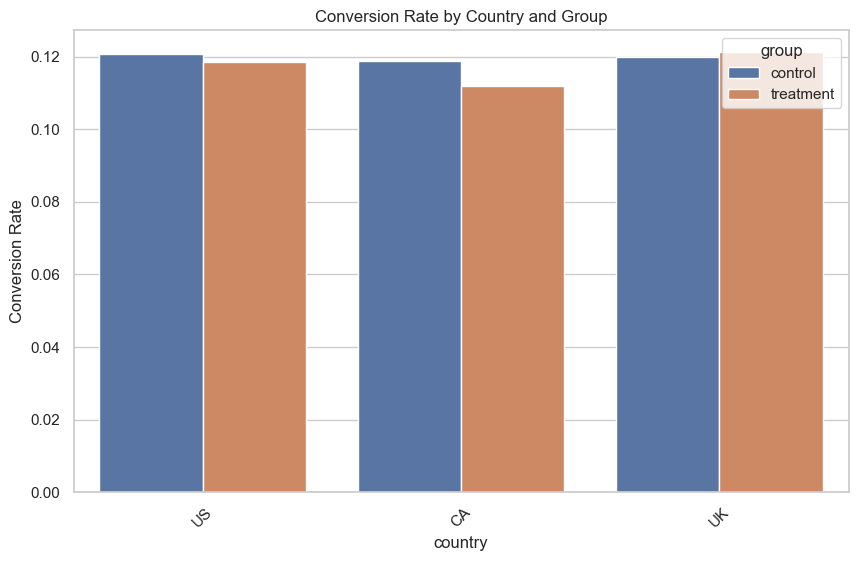

In [12]:
# Exploratory Data Analysis 

# 1. Overall conversion rates
overall_conv_rate = clean_df['converted'].mean()
print(f"Overall Conversion Rate: {overall_conv_rate:.4f}")

# Conversion rate by group (control vs treatment)
conv_rate_by_group = clean_df.groupby('group')['converted'].mean()
print("\nConversion Rate by Group:")
print(conv_rate_by_group)

# 2. Conversion rate by group & country
conv_rate_country_group = clean_df.groupby(['country','group'])['converted'].mean().unstack()
print("\nConversion Rate by Country and Group:")
print(conv_rate_country_group.round(4))

# Add counts as well (to see sample sizes)
conv_counts_country_group = clean_df.groupby(['country','group'])['converted'].agg(['count','sum'])
conv_counts_country_group['conversion_rate'] = conv_counts_country_group['sum'] / conv_counts_country_group['count']
print("\nConversion Counts & Rates by Country and Group:")
print(conv_counts_country_group.round(4))

# Barplot of conversion rate by group
plt.figure(figsize=(6,4))
sns.barplot(x='group', y='converted', data=clean_df, errorbar=None)
plt.title("Conversion Rate by Group")
plt.ylabel("Conversion Rate")
plt.show()

# Conversion by country & group
plt.figure(figsize=(10,6))
sns.barplot(x='country', y='converted', hue='group', data=clean_df, errorbar=None)
plt.title("Conversion Rate by Country and Group")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.show()

### Statistical Testing
1. Two proportion z-test

In [18]:
# Count conversions and sample size per group
conv_counts = clean_df.groupby('group')['converted'].agg(['sum','count'])
print(conv_counts)

conversion_counts = conv_counts['sum'].values
total_users = conv_counts['count'].values

# Two-proportion z-test
z_stat, p_value = proportions_ztest(conversion_counts, total_users)
print(f"\nZ-statistic: {z_stat:.4f}, p-value: {p_value:.4f}")


             sum   count
group                   
control    17489  145274
treatment  17264  145313

Z-statistic: 1.3130, p-value: 0.1892


In [17]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Count conversions and sample size per group
conv_counts = clean_df.groupby('group')['converted'].agg(['sum','count'])
print(conv_counts)

successes = conv_counts['sum'].values  # number of conversions
nobs = conv_counts['count'].values     # total users

# Two-proportion z-test
z_stat, p_val = proportions_ztest(successes, nobs)
print(f"\nZ-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")

# 95% confidence intervals for conversion rate difference
(lower_con, upper_con) = proportion_confint(successes[1], nobs[1], alpha=0.05, method='normal')
(lower_ctrl, upper_ctrl) = proportion_confint(successes[0], nobs[0], alpha=0.05, method='normal')

print(f"\nControl CI: [{lower_ctrl:.3f}, {upper_ctrl:.3f}]")
print(f"Treatment CI: [{lower_con:.3f}, {upper_con:.3f}]")

# Absolute lift (difference)
abs_lift = successes[1]/nobs[1] - successes[0]/nobs[0]
print(f"\nAbsolute Lift: {abs_lift:.4%}")


             sum   count
group                   
control    17489  145274
treatment  17264  145313

Z-statistic: 1.313
P-value: 0.1892

Control CI: [0.119, 0.122]
Treatment CI: [0.117, 0.120]

Absolute Lift: -0.1581%
